In [30]:
# Import Libraries
import pandas as pd

In [31]:
# Load datasets
df1 = pd.read_csv('/Users/atrabaja/Documents/FinMark_DataMining/Customer_Feedback_Data.csv')
df2 = pd.read_csv('/Users/atrabaja/Documents/FinMark_DataMining/Product_Offering_Data.csv')
df3 = pd.read_csv('/Users/atrabaja/Documents/FinMark_DataMining/Transaction_Data.csv')

In [32]:
# Handling Missing Values
# Proper handling of missing data ensures the accuracy of future models.

# For df1 (Customer Feedback Data):

# Satisfaction_Score has missing values. Since this is a critical metric for customer satisfaction, we have two options:
# Option 1 (Preferred): Fill missing values with the mean if the data is symmetrically distributed or median if it's skewed.
# Option 2: Drop rows if missing values are less than 5% of total entries.

# Filling missing satisfaction scores with median for robustness
df1['Satisfaction_Score'] = df1['Satisfaction_Score'].fillna(df1['Satisfaction_Score'].median())

In [33]:
# For df2 (Product Offering Data):

# Target_Age_Group is entirely missing. Since the dataset has no usable data for this column:
# Recommendation: Drop the column unless external data is available.

# Dropping the Target_Age_Group column as it's entirely missing
df2.drop(columns=['Target_Age_Group'], inplace=True)

In [34]:
# For df3 (Transaction Data):

# Transaction_Amount has missing values. We need to investigate whether these missing values are related to specific transaction types.
# Recommendation: If they belong to non-monetary transactions (like "Account Update"), they can be ignored. Otherwise, fill with median.
# Filling missing transaction amounts with median
df3['Transaction_Amount'] = df3['Transaction_Amount'].fillna(df3['Transaction_Amount'].median())

In [35]:
# Data Type Conversion
# Ensure all columns are in the correct data types for accurate analysis.

# Convert Transaction_Date in df3 to datetime format.
# Converting Transaction_Date to datetime
df3['Transaction_Date'] = pd.to_datetime(df3['Transaction_Date'])

In [36]:
# Removing Duplicates
# Duplicate entries can skew results in clustering algorithms.
# Removing duplicates
df1.drop_duplicates(subset='Customer_ID', inplace=True)
df3.drop_duplicates(subset='Transaction_ID', inplace=True)

In [37]:
# Outlier Detection and Handling
# Outliers can distort clustering and segmentation. Use IQR (Interquartile Range) to identify and handle outliers in Transaction_Amount.
# Detecting outliers in Transaction_Amount using IQR
Q1 = df3['Transaction_Amount'].quantile(0.25)
Q3 = df3['Transaction_Amount'].quantile(0.75)
IQR = Q3 - Q1

# Filtering out outliers
df3 = df3[(df3['Transaction_Amount'] >= (Q1 - 1.5 * IQR)) & (df3['Transaction_Amount'] <= (Q3 + 1.5 * IQR))]

In [38]:
# Feature Engineering
# Feature engineering transforms raw data into meaningful inputs for clustering and segmentation.
# Aggregating Transaction Data
# Total_Transaction_Amount: Total spending per customer.
# Transaction_Frequency: Number of transactions per customer.
# Average_Transaction_Amount: Mean transaction per customer.
# Recent_Transaction_Date: Most recent transaction date.

# Aggregating transaction data
transaction_features = df3.groupby('Customer_ID').agg({
    'Transaction_Amount': ['sum', 'mean', 'count'],
    'Transaction_Date': 'max'
}).reset_index()

# Renaming columns for clarity
transaction_features.columns = ['Customer_ID', 'Total_Transaction_Amount', 
                                'Average_Transaction_Amount', 
                                'Transaction_Frequency', 
                                'Recent_Transaction_Date']

In [39]:
# Customer Loyalty Score
# A Customer Loyalty Score can be derived by averaging Satisfaction_Score and Likelihood_to_Recommend in df1.

# Creating Customer Loyalty Score
df1['Customer_Loyalty_Score'] = (df1['Satisfaction_Score'] + df1['Likelihood_to_Recommend']) / 2

In [40]:
# Sentiment Analysis on Feedback Comments
# Analyze Feedback_Comments for sentiment using NLP techniques. This can reveal customer feelings beyond numerical scores.

from textblob import TextBlob

# Sentiment analysis for feedback comments
df1['Sentiment_Score'] = df1['Feedback_Comments'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [41]:
# Merging Datasets
# To create a unified dataset for clustering, merge df1 (customer feedback) with the engineered transaction features from df3.
# Merging feedback and transaction features
final_df = pd.merge(df1, transaction_features, on='Customer_ID', how='left')

In [42]:
# Save the merged dataset to a CSV file
final_df.to_csv('/Users/atrabaja/Documents/FinMark_DataMining/Final_Merged_Dataset.csv', index=False)

print("Merged dataset saved successfully!")

Merged dataset saved successfully!


In [43]:
# Exploratory Data Analysis (EDA)
# EDA helps identify patterns, trends, and anomalies, guiding feature selection for clustering.
# Descriptive Statistics
# Get a summary of key statistics.
# Summary statistics for key metrics
final_df.describe()

,Customer_ID,Satisfaction_Score,Likelihood_to_Recommend,Customer_Loyalty_Score,Sentiment_Score,Total_Transaction_Amount,Average_Transaction_Amount,Transaction_Frequency,Recent_Transaction_Date
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,993.000000,993.000000,993.000000,993
mean,500.500000,5.662000,5.466000,5.564000,0.432250,12496.121853,2489.342604,5.025176,2023-06-19 00:32:30.453172224
min,1.000000,1.000000,1.000000,1.000000,0.000000,286.000000,286.000000,1.000000,2023-01-11 08:00:00
25%,250.750000,3.000000,3.000000,4.000000,0.000000,7771.000000,2006.857143,3.000000,2023-06-02 05:00:00
50%,500.500000,6.000000,5.000000,5.500000,0.650000,11883.000000,2456.800000,5.000000,2023-06-29 18:00:00
75%,750.250000,8.000000,8.000000,7.000000,0.700000,16412.000000,2911.500000,6.000000,2023-07-16 15:00:00
max,1000.000000,60.000000,10.000000,34.500000,1.000000,37281.000000,4993.000000,13.000000,2023-07-28 07:00:00
std,288.819436,3.913447,2.810826,2.449061,0.377856,6363.046841,753.621911,2.180922,NaN


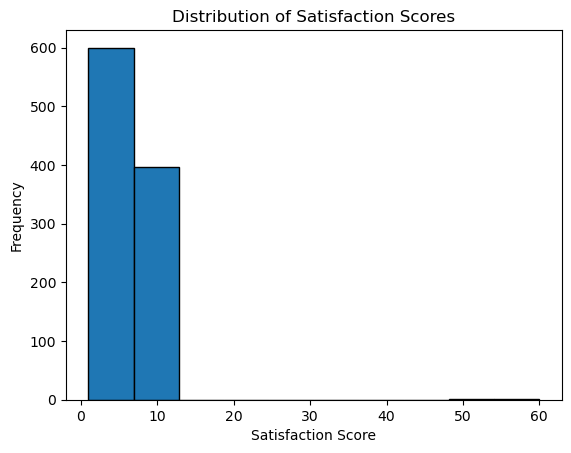

In [44]:
# Distribution Analysis
# Visualize how key metrics like Satisfaction Scores, Transaction Amounts, and Customer Loyalty Scores are distributed.

import matplotlib.pyplot as plt

# Satisfaction Score distribution
plt.hist(final_df['Satisfaction_Score'], bins=10, edgecolor='black')
plt.title('Distribution of Satisfaction Scores')
plt.xlabel('Satisfaction Score')
plt.ylabel('Frequency')
plt.show()

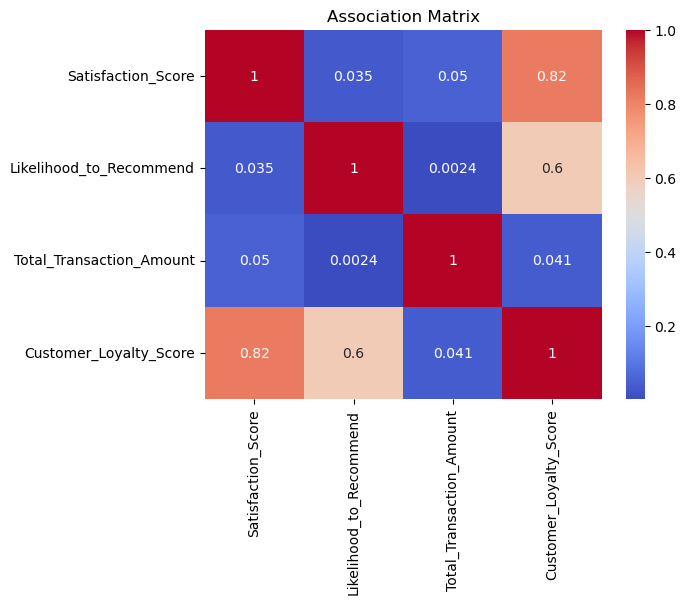

In [45]:
# Association Analysis
# Identify relationships between variables to select the most relevant features for clustering.

import seaborn as sns

# Association matrix
association_matrix = final_df[['Satisfaction_Score', 'Likelihood_to_Recommend',
                               'Total_Transaction_Amount', 'Customer_Loyalty_Score']].corr()

# Heatmap visualization
sns.heatmap(association_matrix, annot=True, cmap='coolwarm')
plt.title('Association Matrix')
plt.show()

       Customer_ID  Satisfaction_Score  Likelihood_to_Recommend  \
count  1000.000000         1000.000000              1000.000000   
mean    500.500000            5.662000                 5.466000   
min       1.000000            1.000000                 1.000000   
25%     250.750000            3.000000                 3.000000   
50%     500.500000            6.000000                 5.000000   
75%     750.250000            8.000000                 8.000000   
max    1000.000000           60.000000                10.000000   
std     288.819436            3.913447                 2.810826   

       Customer_Loyalty_Score  Sentiment_Score  Total_Transaction_Amount  \
count             1000.000000      1000.000000                993.000000   
mean                 5.564000         0.432250              12496.121853   
min                  1.000000         0.000000                286.000000   
25%                  4.000000         0.000000               7771.000000   
50%             

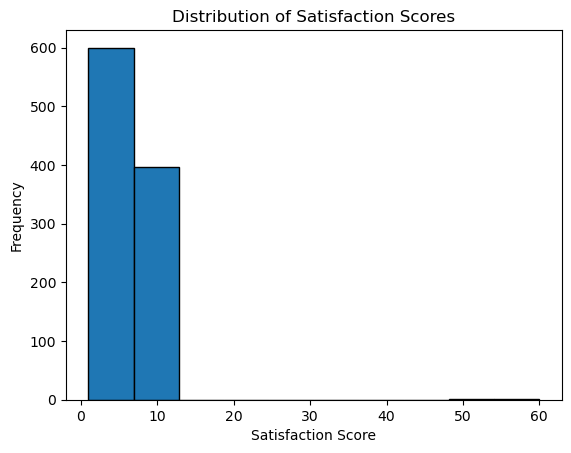

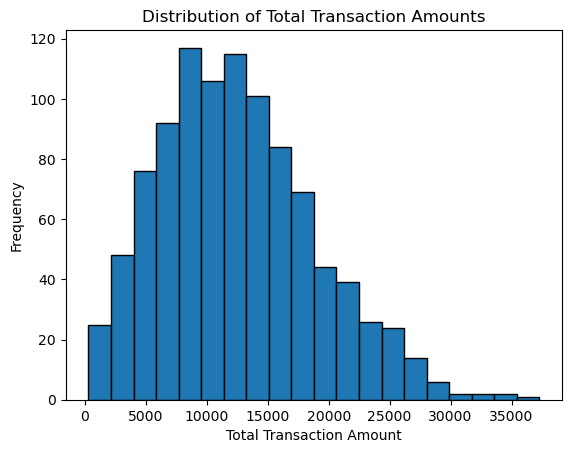

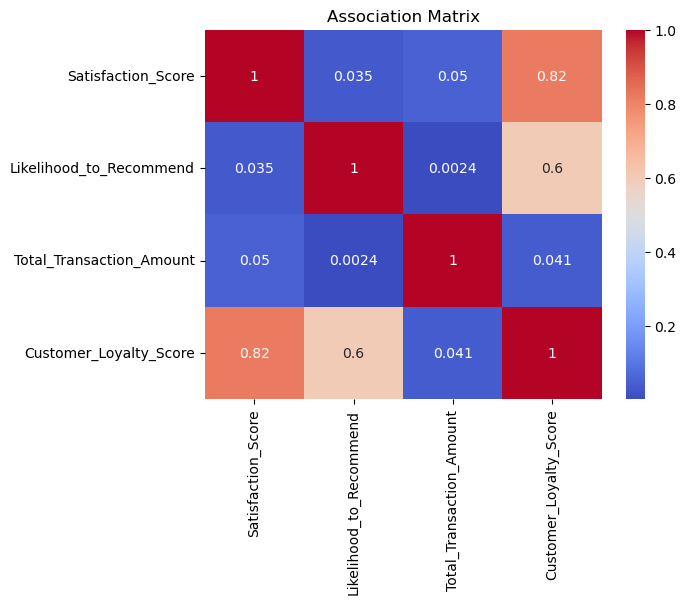

Data preparation and exploratory analysis complete. Ready for clustering and segmentation in Milestone 2.


In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob

# Load datasets
df1 = pd.read_csv('/Users/atrabaja/Documents/FinMark_DataMining/Customer_Feedback_Data.csv')
df2 = pd.read_csv('/Users/atrabaja/Documents/FinMark_DataMining/Product_Offering_Data.csv')
df3 = pd.read_csv('/Users/atrabaja/Documents/FinMark_DataMining/Transaction_Data.csv')

# ==========================
# Data Cleaning and Preparation
# ==========================

# Handling Missing Values
# 1. Customer Feedback Data (df1)
df1['Satisfaction_Score'] = df1['Satisfaction_Score'].fillna(df1['Satisfaction_Score'].median())

# 2. Product Offering Data (df2)
df2.drop(columns=['Target_Age_Group'], inplace=True)  # Dropping entirely missing column

# 3. Transaction Data (df3)
df3['Transaction_Amount'] = df3['Transaction_Amount'].fillna(df3['Transaction_Amount'].median())

# Data Type Conversion
df3['Transaction_Date'] = pd.to_datetime(df3['Transaction_Date'])

# Removing Duplicates
df1.drop_duplicates(subset='Customer_ID', inplace=True)
df3.drop_duplicates(subset='Transaction_ID', inplace=True)

# Outlier Detection and Removal (IQR method)
Q1 = df3['Transaction_Amount'].quantile(0.25)
Q3 = df3['Transaction_Amount'].quantile(0.75)
IQR = Q3 - Q1
df3 = df3[(df3['Transaction_Amount'] >= (Q1 - 1.5 * IQR)) & (df3['Transaction_Amount'] <= (Q3 + 1.5 * IQR))]

# ==========================
# Feature Engineering
# ==========================

# Aggregating Transaction Data
transaction_features = df3.groupby('Customer_ID').agg({
    'Transaction_Amount': ['sum', 'mean', 'count'],
    'Transaction_Date': 'max'
}).reset_index()

# Renaming columns
transaction_features.columns = ['Customer_ID', 'Total_Transaction_Amount', 'Average_Transaction_Amount', 
                                'Transaction_Frequency', 'Recent_Transaction_Date']

# Customer Loyalty Score
df1['Customer_Loyalty_Score'] = (df1['Satisfaction_Score'] + df1['Likelihood_to_Recommend']) / 2

# Sentiment Analysis on Feedback Comments
df1['Sentiment_Score'] = df1['Feedback_Comments'].apply(lambda x: TextBlob(x).sentiment.polarity)

# ==========================
# Merging Datasets
# ==========================

# Merging feedback and transaction features
final_df = pd.merge(df1, transaction_features, on='Customer_ID', how='left')

# ==========================
# Exploratory Data Analysis (EDA)
# ==========================

# Descriptive Statistics
print(final_df.describe())

# Distribution of Satisfaction Scores
plt.hist(final_df['Satisfaction_Score'], bins=10, edgecolor='black')
plt.title('Distribution of Satisfaction Scores')
plt.xlabel('Satisfaction Score')
plt.ylabel('Frequency')
plt.show()

# Distribution of Total Transaction Amounts
plt.hist(final_df['Total_Transaction_Amount'], bins=20, edgecolor='black')
plt.title('Distribution of Total Transaction Amounts')
plt.xlabel('Total Transaction Amount')
plt.ylabel('Frequency')
plt.show()

# Association Analysis
association_matrix = final_df[['Satisfaction_Score', 'Likelihood_to_Recommend',
                               'Total_Transaction_Amount', 'Customer_Loyalty_Score']].corr()

sns.heatmap(association_matrix, annot=True, cmap='coolwarm')
plt.title('Association Matrix')
plt.show()

# ==========================
# Documentation of Findings
# ==========================

# Key insights and next steps will be documented outside this script as part of the project report.
print("Data preparation and exploratory analysis complete. Ready for clustering and segmentation in Milestone 2.")


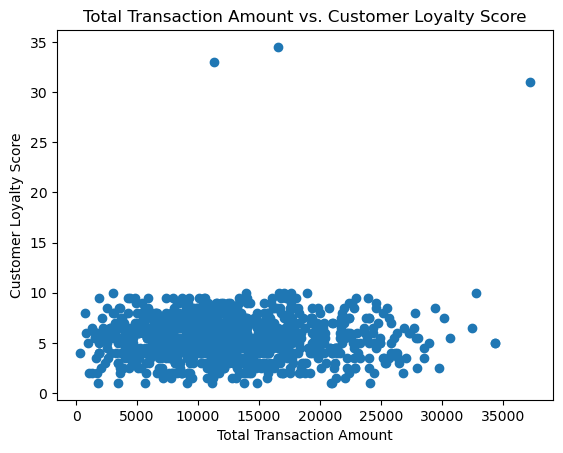

In [49]:
# Scatter Plot of Total Transaction Amount vs. Customer Loyalty Score
plt.scatter(final_df['Total_Transaction_Amount'], final_df['Customer_Loyalty_Score'])
plt.title('Total Transaction Amount vs. Customer Loyalty Score')
plt.xlabel('Total Transaction Amount')
plt.ylabel('Customer Loyalty Score')
plt.show()